In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import seaborn as sns

df1_slow = pd.read_csv('benchmark_data/s1-signal-slow.csv')
df1_fast = pd.read_csv('benchmark_data/s1-signal-fast.csv')
output_dir = 'benchmark_plots'

for df in [df1_slow, df1_fast]: 
    # Compute number of received packets
    num_packets = len(df)
    
    # Compute duration (in ms) from first to last receiving timestamp
    duration_ms = df["receivingTimestamp"].max() - df["receivingTimestamp"].min()
    
    # Rate: packets per ms
    rate_per_ms = num_packets / duration_ms
    
    # Convert to packets per second for readability
    rate_per_sec = rate_per_ms * 1000
    
    print(f"Edits received: {num_packets}")
    print(f"Duration: {duration_ms} ms")
    print(f"Rate: {rate_per_ms:.6f} edits/ms ({rate_per_sec:.3f} packets/s)")

Edits received: 2597
Duration: 5642 ms
Rate: 0.460298 edits/ms (460.298 packets/s)
Edits received: 2597
Duration: 5658 ms
Rate: 0.458996 edits/ms (458.996 packets/s)


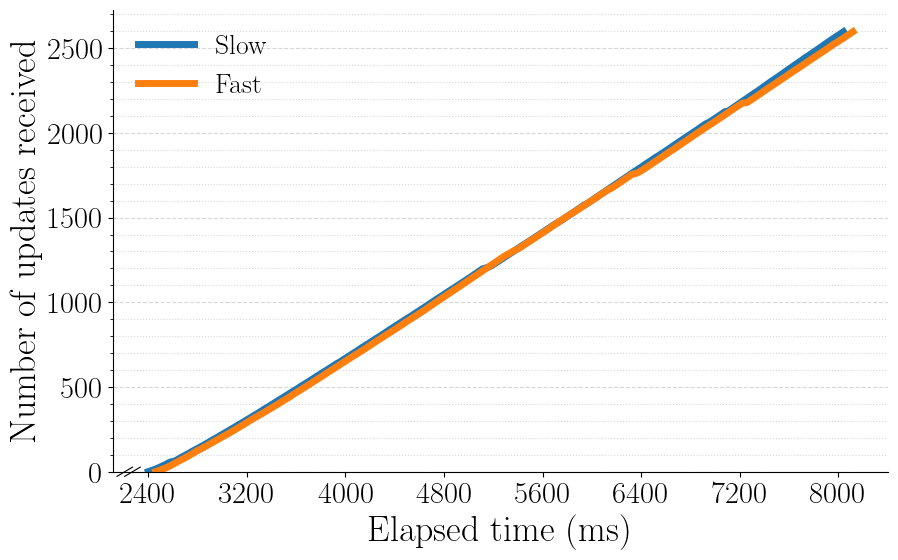

In [11]:
import os
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator, FormatStrFormatter)

# Matplotlib/LaTeX settings
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],  # let LaTeX pick the default serif (Times)
    "text.latex.preamble": r"\usepackage{amsmath}",
    "axes.titlesize" : 28,
    "axes.labelsize" : 26,
    "lines.linewidth" : 5,
    "lines.markersize" : 18,
    "xtick.labelsize" : 22,
    "ytick.labelsize" : 22,
    "legend.fontsize": 20
})

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# --- Common logic abstracted into a helper ---

def plot_updates(ax, df, label, marker='.', linestyle='-'):
    """Sort by receive time, compute derived series, and plot updates received.

    Returns the processed DataFrame with columns: elapsed_ms, updates_received, cum_update_bytes.
    """
    # Normalize time to the dataset's own start
    start_time = df['startTimestamp'].min()

    # Sort by receive time and compute derived series
    df_sorted = df.sort_values('receivingTimestamp').reset_index(drop=True)
    df_sorted['elapsed_ms'] = df_sorted['receivingTimestamp'] - start_time
    df_sorted['updates_received'] = df_sorted.index + 1
    df_sorted['cum_update_bytes'] = df_sorted['updateSize'].cumsum()

    # Plot updates received
    ax.plot(
        df_sorted['elapsed_ms'],
        df_sorted['updates_received'],
        marker=marker,
        linestyle=linestyle,
        label=label,
    )
    return df_sorted

# --- Create plot with both slow and fast on the same axes ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both datasets using the shared helper
slow_proc = plot_updates(ax, df1_slow, label='Slow', marker='')
fast_proc = plot_updates(ax, df1_fast, label='Fast', marker='')

ax.set_xlabel('Elapsed time (ms)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Small x-axis break marks at lower-left
d = 0.01  # size in axes coordinates
shift = 0.01
shift_l = 0.015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth=0.8)
ax.plot((-d+shift_l, +d+shift_l), (-d, +d), **kwargs)
ax.plot((-d+shift_l+shift, +d+shift_l+shift), (-d, +d), **kwargs)

ax.set_ylabel('Number of updates received')
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=0)
ax.yaxis.grid(True, which='minor', linestyle='dotted', alpha=0.5)
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

ax.spines['right'].set_visible(False)
# Secondary y-axis for cumulative size (kB) with grid lines
#ax2 = ax.twinx()
#ax2.spines['top'].set_visible(False)

# Determine max cumulative size across both for a sensible scale
#max_cum_kb = max(slow_proc['cum_update_bytes'].iloc[-1], fast_proc['cum_update_bytes'].iloc[-1]) / 1024

# Plot invisible lines to drive axis/grid scale (we just want the axis/grid)
#ax2.plot(slow_proc['elapsed_ms'], slow_proc['cum_update_bytes'] / 1024, linestyle='--', alpha=0)
#ax2.plot(fast_proc['elapsed_ms'], fast_proc['cum_update_bytes'] / 1024, linestyle='--', alpha=0)

#ax2.set_ylabel('Cumulative size of updates (kB)')
#ax2.set_ylim(bottom=0, top=max_cum_kb * 1.05)
#ax2.yaxis.set_major_locator(MultipleLocator(100))
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%d kB'))
#ax2.yaxis.grid(True, which='major', linestyle='dotted', alpha=0.5)

# Legend for the two time series
ax.legend(loc='upper left', frameon=False)

# Save and show
plt.savefig(f'{output_dir}/s1-cumulative-both.svg',bbox_inches='tight')
plt.savefig(f'{output_dir}/s1-cumulative-both.pdf',bbox_inches='tight')
plt.show()
